# Project 9

## Task 2

In [4]:
import numpy as np
import itertools
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt

In [5]:
A = np.array([
    [0, 1, 1, 1],
    [1, 0, 1, 0],
    [1, 1, 0, 1],
    [1, 0, 1, 0]
])

# Analytical solution
k = A.sum(axis=1) # degrees
pi_analytical = k / k.sum() # P9.1 formula

# MArkov operator
P = A.T / k

# Eigenvector
eigvals, eigvecs = np.linalg.eig(P)
idx = np.argmin(np.abs(eigvals - 1))
pi_numerical = np.real(eigvecs[:, idx])
pi_numerical = pi_numerical / pi_numerical.sum()

# comparison
print("Analytical PI:", pi_analytical)
print("Numerical PI :", pi_numerical)

Analytical PI: [0.3 0.2 0.3 0.2]
Numerical PI : [0.3 0.2 0.3 0.2]


## Task 3

In [6]:
def compare_methods(A):
    # Analytical solution
    k = A.sum(axis=1) # degrees
    pi_analytical = k / k.sum() # P9.1 formula

    # MArkov operator
    P = A.T / k

    # Eigenvector
    eigvals, eigvecs = np.linalg.eig(P)
    idx = np.argmin(np.abs(eigvals - 1))
    pi_numerical = np.real(eigvecs[:, idx])
    pi_numerical = pi_numerical / pi_numerical.sum()

    # Simulation
    n = len(A)
    pi = np.ones(n) / n # initial probs

    for _ in range(1000):
        pi = P @ pi

    pi_dynamic = pi

    # comparison
    print("Analytical PI:", pi_analytical)
    print("Numerical PI :", pi_numerical)
    print("Dynamic PI:", pi_dynamic)



In [7]:
compare_methods(A)

Analytical PI: [0.3 0.2 0.3 0.2]
Numerical PI : [0.3 0.2 0.3 0.2]
Dynamic PI: [0.3 0.2 0.3 0.2]


In [8]:
def random_connected_graph(n, p=0.3):
    while True:
        G = nx.erdos_renyi_graph(n, p)
        if nx.is_connected(G):
            break
    return nx.to_numpy_array(G, dtype=int)

In [9]:
A = random_connected_graph(10)

In [10]:
compare_methods(A)

Analytical PI: [0.07692308 0.07692308 0.07692308 0.15384615 0.11538462 0.03846154
 0.15384615 0.15384615 0.03846154 0.11538462]
Numerical PI : [0.07692308 0.07692308 0.07692308 0.15384615 0.11538462 0.03846154
 0.15384615 0.15384615 0.03846154 0.11538462]
Dynamic PI: [0.07692308 0.07692308 0.07692308 0.15384615 0.11538462 0.03846154
 0.15384615 0.15384615 0.03846154 0.11538462]


## Taks 6

In [ ]:
def get_eigenvals(A):
    k = A.sum(axis=1)
    P = A.T / k
    eigvals = np.linalg.eigvals(P)
    eigvals = np.sort(np.abs(eigvals))
    return eigvals

In [112]:
def random_connected_graph_nm(n, m, seed=None):
    if m < n - 1:
        raise ValueError("Graph cannot be connected, m < n - 1")
    if m > n * (n-1) // 2:
        raise ValueError("Too much edges")
    
    random.seed(seed)

    G = nx.random_spanning_tree(nx.complete_graph(n), seed=seed)
    G = nx.Graph(G)
    possible_edges = list(nx.non_edges(G))
    random.shuffle(possible_edges)
    edges_to_add = m - (n - 1)
    G.add_edges_from(possible_edges[:edges_to_add])
    return G

In [41]:
def dynamic_diffusion_speed(G, T=100):
    A = nx.to_numpy_array(G)
    k = A.sum(axis=1)
    P = A.T / k
    pi = k / k.sum()

    n = len(pi)
    p = np.zeros(n)
    p[0] = 1.0  # start fully localized

    distances = []

    for t in range(T):
        p = P @ p
        dist = np.linalg.norm(p - pi, ord=1)
        distances.append(dist)

    return np.array(distances)

In [42]:
def fit_decay_rate(distances):
    eps = 1e-12
    y = np.log(distances + eps)
    x = np.arange(len(y))

    slope, _ = np.polyfit(x, y, 1)
    return -slope  # larger = faster diffusion

In [99]:
def analyze_graph(G):
    degrees = [d for _, d in G.degree()]
    lam2 = get_eigenvals(nx.to_numpy_array(G))[-2]
    distances = dynamic_diffusion_speed(G, T=50)
    rate = fit_decay_rate(distances)

    return ({
        "graph": G,
        "lambda2": lam2,
        "degrees": degrees,
        "deg_var": np.var(degrees),
        "dynamic_diff_rate": rate
    })

In [113]:
n = 7
m = 12
records = []
for _ in range(1000):
    G = random_connected_graph_nm(n, m)
    records.append(analyze_graph(G))
results = pd.DataFrame(records)

In [114]:
results.sort_values(by="dynamic_diff_rate", ascending=False)

,graph,lambda2,degrees,deg_var,dynamic_diff_rate
653,"(1, 2, 0, 6, 4, 5, 3)",0.500000,"[2, 4, 4, 4, 2, 4, 4]",0.816327,0.625167
340,"(2, 4, 1, 6, 0, 5, 3)",0.500000,"[2, 4, 4, 4, 4, 4, 2]",0.816327,0.625167
861,"(0, 1, 4, 5, 2, 6, 3)",0.602712,"[2, 5, 2, 4, 5, 2, 4]",1.673469,0.621819
915,"(2, 4, 1, 5, 0, 3, 6)",0.602712,"[2, 5, 4, 4, 2, 5, 2]",1.673469,0.621818
210,"(1, 2, 3, 4, 5, 6, 0)",0.500000,"[2, 4, 2, 3, 5, 3, 5]",1.387755,0.619397
...,...,...,...,...,...
862,"(0, 4, 1, 5, 3, 6, 2)",0.893855,"[4, 3, 4, 3, 4, 3, 3]",0.244898,0.112335
39,"(0, 4, 3, 6, 2, 5, 1)",0.893855,"[4, 3, 3, 3, 4, 4, 3]",0.244898,0.112335
291,"(1, 2, 0, 3, 4, 6, 5)",0.893855,"[4, 3, 3, 4, 3, 4, 3]",0.244898,0.112335
729,"(0, 4, 3, 6, 2, 5, 1)",0.893855,"[3, 4, 3, 3, 3, 4, 4]",0.244898,0.112291


In [118]:
results["graph"][653].edges()

EdgeView([(1, 2), (1, 3), (2, 6), (2, 3), (2, 0), (0, 6), (0, 5), (0, 3), (6, 5), (6, 4), (4, 5), (5, 3)])

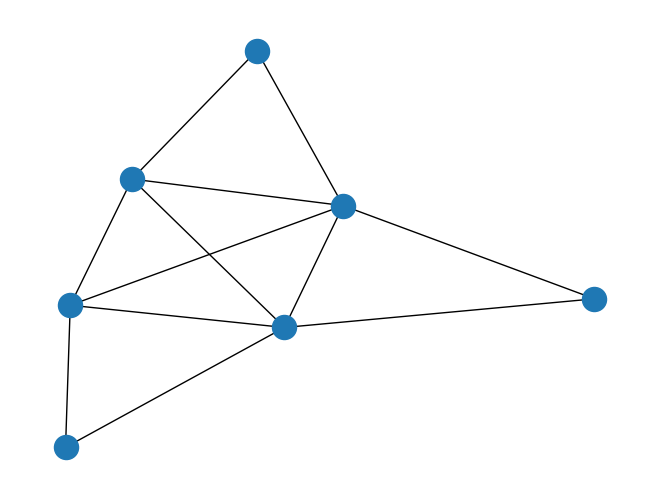

In [121]:
nx.draw(results["graph"][861])

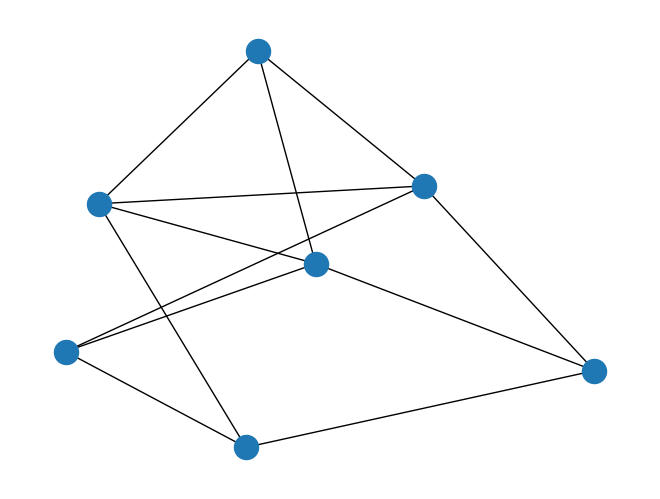

In [120]:
nx.draw(results["graph"][729])

In [126]:
n = 10
m = 9
records = []
for _ in range(1000):
    G = random_connected_graph_nm(n, m)
    records.append(analyze_graph(G))
results = pd.DataFrame(records)

In [123]:
results.sort_values(by="dynamic_diff_rate", ascending=False)

,graph,lambda2,degrees,deg_var,dynamic_diff_rate
47,"(0, 1, 2, 4, 6, 3, 5)",1.0,"[1, 2, 2, 1, 2, 2, 2]",0.204082,3.968403e-03
401,"(0, 1, 2, 4, 6, 5, 3)",1.0,"[1, 2, 2, 2, 2, 2, 1]",0.204082,3.968403e-03
72,"(0, 1, 2, 4, 6, 5, 3)",1.0,"[1, 2, 2, 2, 2, 2, 1]",0.204082,3.968403e-03
664,"(2, 4, 1, 5, 0, 6, 3)",1.0,"[1, 2, 2, 2, 2, 2, 1]",0.204082,3.968403e-03
728,"(0, 1, 2, 4, 5, 6, 3)",1.0,"[1, 2, 2, 2, 2, 2, 1]",0.204082,3.968403e-03
...,...,...,...,...,...
698,"(2, 4, 1, 3, 0, 6, 5)",1.0,"[5, 1, 1, 2, 1, 1, 1]",1.918367,-1.557778e-17
35,"(1, 2, 5, 4, 0, 6, 3)",1.0,"[5, 1, 2, 1, 1, 1, 1]",1.918367,-1.988539e-17
509,"(0, 1, 5, 4, 2, 6, 3)",1.0,"[2, 5, 1, 1, 1, 1, 1]",1.918367,-2.233774e-17
142,"(1, 2, 5, 0, 3, 4, 6)",1.0,"[5, 1, 1, 1, 2, 1, 1]",1.918367,-4.262830e-17


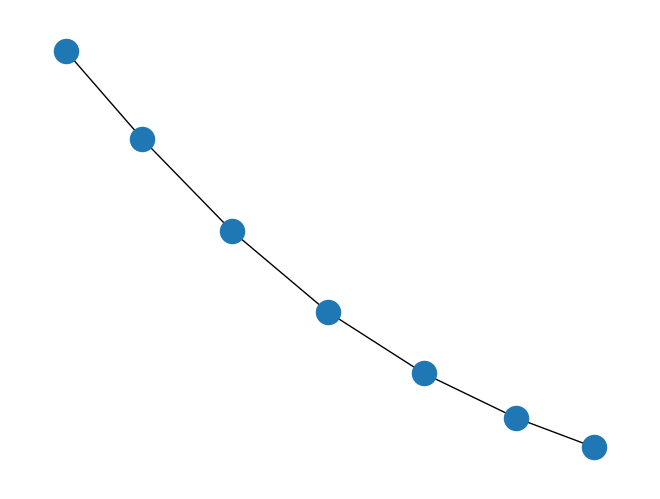

In [124]:
nx.draw(results["graph"][47])

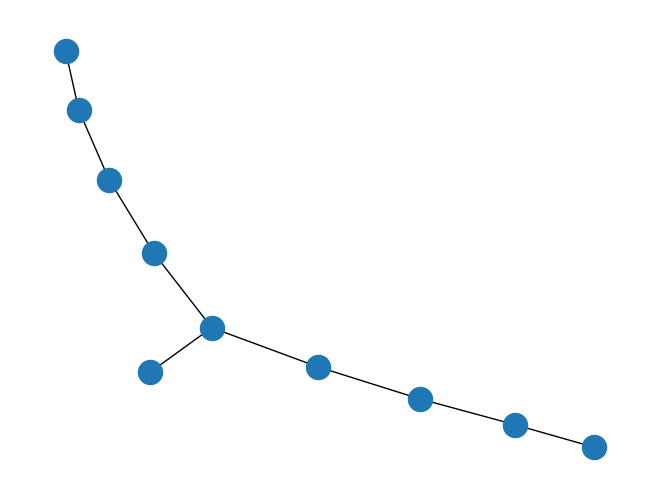

In [128]:
nx.draw(results["graph"][401])

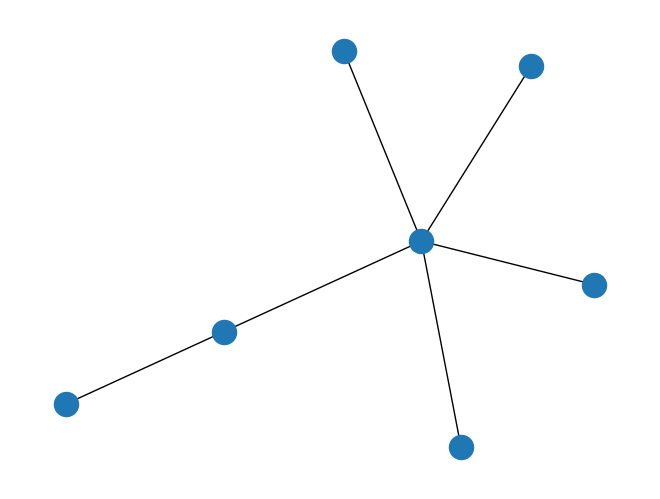

In [125]:
nx.draw(results["graph"][558])

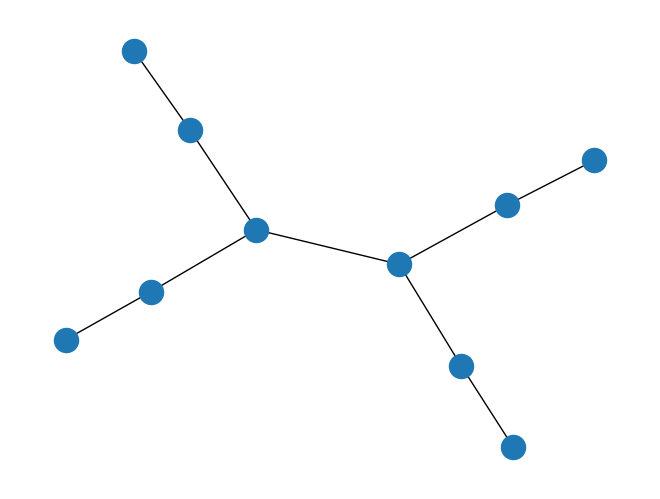

In [129]:
nx.draw(results["graph"][509])

In [ ]:
plt.plot()

# 9.5 PAGERANK

In [47]:
def pagerank(A, alpha=0.85, T=1000):
    k = A.sum(axis=1)

    # separate nodes
    k[k == 0] = 1

    P = A.T / k

    n = len(A)
    v = np.ones(n) / n # uniform teleportation
    pi = np.ones(n) / n # initial distribution

    for _ in range(T):
        pi = alpha * (P @ pi) + (1 - alpha) * v

    return pi

In [19]:
def pagerank_mod(A, v, alpha=0.85, T=1000):
    k = A.sum(axis=1)
    k[k == 0] = 1

    P = A.T / k

    pi = np.ones(len(A)) / len(A)

    for _ in range(T):
        pi = alpha * (P @ pi) + (1 - alpha) * v

    return pi

In [20]:
A = random_connected_graph(10)

In [21]:
compare_methods(A)

Analytical PI: [0.15384615 0.07692308 0.07692308 0.11538462 0.07692308 0.23076923
 0.07692308 0.07692308 0.03846154 0.07692308]
Numerical PI : [0.15384615 0.07692308 0.07692308 0.11538462 0.07692308 0.23076923
 0.07692308 0.07692308 0.03846154 0.07692308]
Dynamic PI: [0.15384615 0.07692308 0.07692308 0.11538462 0.07692308 0.23076923
 0.07692308 0.07692308 0.03846154 0.07692308]


In [22]:
pagerank(A)

array([0.15340802, 0.07786689, 0.07872641, 0.11210061, 0.08054994,
       0.21365424, 0.07872641, 0.07950141, 0.0475992 , 0.07786689])

In [23]:
sum(pagerank(A))

np.float64(0.9999999999999999)

In [44]:
v = np.array(range(20, 1, -2))
v = v/v.sum()

In [45]:
v

array([0.18181818, 0.16363636, 0.14545455, 0.12727273, 0.10909091,
       0.09090909, 0.07272727, 0.05454545, 0.03636364, 0.01818182])

In [46]:
pagerank_mod(A, v=v)

array([0.16027212, 0.08871602, 0.08465623, 0.11745173, 0.08044767,
       0.21256049, 0.07700072, 0.07248482, 0.03951237, 0.06689783])